# CLASSIFICATION OF R/SOURDOUGH POSTS PER FLAIR TAGS: 10 - RESULTS AND DISCUSSION

## 1) Introduction

### 1.1) General presentation: 

The aim of this project is to help predict the category of a post on the r/sourdough subreddit, based on its text content: its title, the content of the post itself and of the comments. More details on the general context of the project are provided in the first notebook : [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

The main strategy employed for the preprocessing of the data was a Bag-of-words approach, where the cleaning (cleaning, removing punctuation, numbers and  urls, lemmatization) and tokenization (splitting of the strings in smaller units; here words) was followed by counting each unique words to define the vocabulary. Then, each word was represented by its freqency in each post, pondered by its freqency in the whole corpus. The TF-IDF vectorizer was tuned to remove the noise(i.e.: words too frequent as well as words not frequent enough). 

In addition, posts categories were explored, and it was decided to regroup them in meta categories, as the large number of initial categories (40), paired with the large imbalance (some categories only having 1 observation, when others had  almost a thousand) would have lead to poor performance for the classifiers. 

Thus, the preprocessing resulted in two dataset: 
* A training set with 6713 observations and 1195 features that will be used to train our machine learning models through cross validation
* A test set with 2878 observations and 1195 features that will be used to test the performance of our models. 

The meta classes to predict, constructed based on insider knowledge of the r/sourdough subreddit are as follows: 
* Critique
* Discussion
* Help
* Look 

The Machine learning strategy for the project is as follows: 
1. Train multiple classifiers on the training set, using cross validation to tune the hyperparameters. These models, referred to as 0-level classifiers,  are: 
* Naive Bayes
* Logistic Regression
* K nearest neighbors
* Decision Tree
* Random Forest
* Support Vector Machine with a non linear kernel

2. Produce 5-folds out of bag predictions on the training set (divide the training set in 5 folds, fitting the optimal model on the first 4 folds to predict the fifth, repeat % times) from all 0-level classifiers and use these to perform a quick data exploration of the predictions. 

3. Stack the 0-level classifiers and train and fine tune the meta classifier. 

4. Evaluate all predictions(0-level and meta-classifier), by comparing their performance to a dummy classifier, using a stratified strategy (prediction randomly drawn from a distribution computed from the target variable distribution in the training set)

5. At the end of the process, we will discuss our results as well as the challenges we faced and the possible points of improvements that could be considered for the project. 

### 1.2) Aim of this notebook
This notebook aims at evaluating the predictive performance of all models that were considered during this project and benchmark them against a base model. 
The base model that was chosen is a dummy classifier, where the predictions are randomly drawn from a distribution computed from the target variable distribution in the training set. 

## 2) Computing the base model 

In [1]:
#load library

import pandas as pd
import requests
import json
import csv
import time
import datetime
import numpy as np
import re 
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# compare ensemble to each baseline classifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

In [2]:
#load data
train_df = pd.read_csv('data/train/train_preprocessed_sourdough.csv', sep = '\t')
test_df = pd.read_csv('data/test/test_preprocessed_sourdough.csv', sep = '\t')


X_tr = train_df["standard_text"].values
X_te = test_df["standard_text"].values

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_tr = train_df["Flair_process"]
y_tr_enc = LE.fit_transform(y_tr)

y_te = test_df["Flair_process"]
y_te_enc = LE.transform(y_te)

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#import best parameters for tf_idf
vec = open("./data/train/Tfidf_parameters.pickle", 'rb') # rb= read in bytes
tf_idf_search  = pickle.load(vec)
vec.close()
# Calculate TF-IDF
tf_idf = TfidfVectorizer(#max_features=tf_idf_search.best_params_['vect__max_features'],
                         min_df =tf_idf_search.best_params_['vect__min_df'], 
                         max_df = tf_idf_search.best_params_['vect__max_df'], 
                         use_idf = tf_idf_search.best_params_['vect__use_idf']
                        )

X_train_tfidf = tf_idf.fit_transform(X_tr)
X_test_tfidf = tf_idf.transform(X_te)

As a remeinder, the Flair distribution is displayed below. 

In [3]:
# Compute distribution on training set: 

pd.Series(y_tr).value_counts(normalize=True)

Look          0.316550
Help          0.287204
Discussion    0.226724
Critique      0.169522
Name: Flair_process, dtype: float64

In [4]:
from sklearn.dummy import DummyClassifier  

# Create the dummy classifier 

dummy = DummyClassifier(strategy='stratified')

#Fit 
dummy.fit(None, y_tr)

# Compute the test accuracy

base_accuracy = dummy.score(None, y_te)
print('Base Accuracy Accuracy: {:.2f}'.format(base_accuracy))

Base Accuracy Accuracy: 0.26


In [5]:
from sklearn.metrics import f1_score
print('Base Weighted F1 score: {:.2f}'.format(f1_score(y_te, dummy.predict(X_test_tfidf), average = 'weighted')))

Base Weighted F1 score: 0.26


The classification report is displayed below: 

In [6]:
 print(classification_report(y_te, dummy.predict(X_test_tfidf), target_names = LE.classes_))

              precision    recall  f1-score   support

    Critique       0.19      0.19      0.19       488
  Discussion       0.23      0.23      0.23       652
        Help       0.28      0.27      0.28       827
        Look       0.33      0.33      0.33       911

    accuracy                           0.27      2878
   macro avg       0.26      0.26      0.26      2878
weighted avg       0.27      0.27      0.27      2878



For all classes, both the precision and recall are very low and not surprisingly, classes with more observations are the classes with the best results:  
* Only 19% of the posts that are predicted as Critique actually belong to this class, and only 19% of the posts in this flair are correctly predicted. 
* Only 22% of the posts predicted as Discussion actually belong to this class, and 22% of the of the posts in this flair are being correctly predicted.
* Only 29% of the posts predicted as Critique actually belong to this class, and 31% of the of the posts in this flair are being correctly predicted. 
* Finally, only 30% of the posts predicted as Look actually belong to this class, and 29% of the of the posts in this flair are being correctly predicted. 

The confusion matrix below shows this by displaying the repartition of the predictions in each classe: 

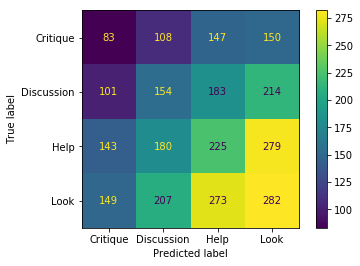

In [7]:
disp = ConfusionMatrixDisplay(
        confusion_matrix(y_te,  dummy.predict(X_test_tfidf)),
        display_labels=LE.classes_,
        #cmap=plt.cm.Blues,
        #normalize=True,
    ).plot()
#disp.ax_.set_title("Confusion matrix")

#print(title)
#print(disp.confusion_matrix)

plt.show()


## 3) Comparison of all models

We can now load all models to perform a final comparison of our results: 

In [8]:
#loading all data 
# loading previous results

# load the model from disk
bayes_final, oof_bayes_proba_pred, oof_bayes_class_pred, oof_bayes_true = pickle.load(open('results/01_bayes.sav', 'rb'))
bayes_proba_pred =  pd.DataFrame(oof_bayes_proba_pred,columns = "bayes_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
logreg_final, oof_logreg_proba_pred, oof_logreg_class_pred,  oof_logreg_true  = pickle.load(open('results/02_logreg.sav', 'rb'))
lr_proba_pred = pd.DataFrame(oof_logreg_proba_pred ,columns = "lr_"+LE.classes_, index =train_df["Post ID_x"])
    
    
# load the model from disk
knn_final, oof_knn_proba_pred, oof_knn_class_pred, oof_knn_true = pickle.load(open('results/03_knn.sav', 'rb'))
knn_proba_pred = pd.DataFrame(oof_knn_proba_pred,columns = "knn_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
cart_final,oof_cart_proba_pred, oof_cart_class_pred, oof_cart_true = pickle.load(open('results/04_cart.sav', 'rb'))
cart_proba_pred = pd.DataFrame(oof_cart_proba_pred,columns = "cart_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
rf_final,oof_rf_proba_pred, oof_rf_class_pred, oof_rf_true = pickle.load(open('results/05_rf.sav', 'rb'))
rf_proba_pred = pd.DataFrame(oof_rf_proba_pred,columns = "rf_"+LE.classes_, index =train_df["Post ID_x"])
 


# load the model from disk
svc_final, oof_svc_proba_pred, oof_svc_class_pred, oof_svc_true = pickle.load(open('results/06_svc.sav', 'rb'))
svc_proba_pred = pd.DataFrame(oof_svc_proba_pred,columns = "svc_"+LE.classes_, index =train_df["Post ID_x"])


# Load meta model 
meta_final = pickle.load(open('results/07_stack.sav', 'rb'))

### Weighted average f1-score



In [9]:
all_results = pd.DataFrame({'base' : [f1_score(y_te, dummy.predict(X_test_tfidf), average = 'weighted') *100], 
                            'bayes' : [f1_score(y_te_enc, bayes_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            "Logistic regression" : [f1_score(y_te_enc, logreg_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            'knn' : [f1_score(y_te_enc, knn_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            'cart' : [f1_score(y_te_enc, cart_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            'random forest' : [f1_score(y_te_enc, rf_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            'rbf svm' : [f1_score(y_te_enc, svc_final.predict(X_test_tfidf), average = 'weighted')*100], 
                            'stacking' : [f1_score(y_te_enc, meta_final.predict(X_test_tfidf), average = 'weighted')*100], 
                           }, index = ['test_f1']).T

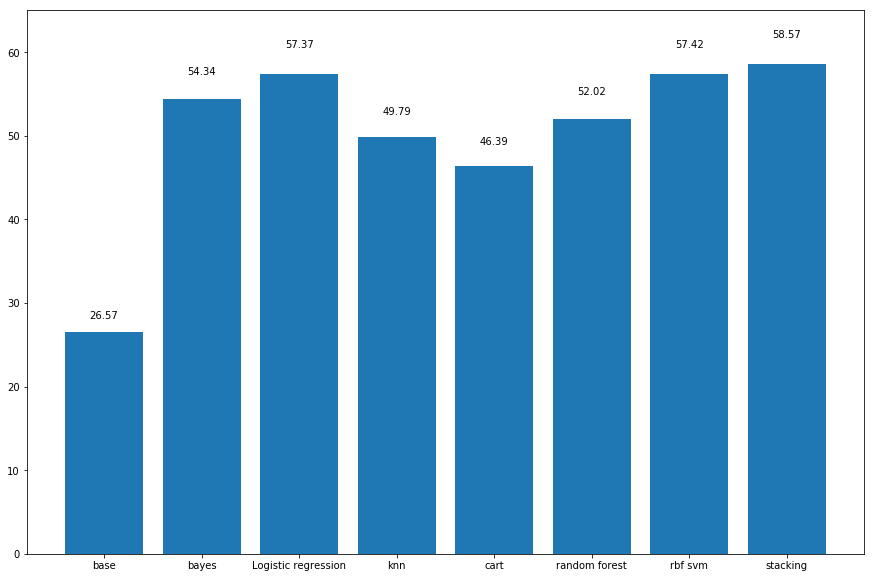

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
bar_plot = plt.bar(x =all_results.index , height = all_results['test_f1'])
plt.ylim([0, 65])
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                np.round(all_results['test_f1'].values, 2)[idx],
                ha='center', va='bottom', rotation=0)
autolabel(all_results['test_f1'].values)
plt.show()
        
    

Even if the classification performances are not very good (only around 58% at best), all models perform way better than the dummy classifier (only 25%). 

The classifiers with the best weighted F1 score are the stacking classifier, followed by the non linear SVM, and the logistic regression. 
The stacking classifier even managed to slightly outperform the SVM, while this classifier was not used in the stack, while being computationally more efficient (less than a 10 minutes run for the grid search, vs 2 hours for the SVM grid search). 

Similarly, we can compare the precision and recall for each class and all models: 

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [12]:
# build precision scores dataframe

all_prec = pd.DataFrame({'base': precision_score(y_te, dummy.predict(X_test_tfidf), average = None),
                         'bayes': precision_score(y_te_enc, bayes_final.predict(X_test_tfidf), average = None), 
                         'logistic regression': precision_score(y_te_enc, logreg_final.predict(X_test_tfidf), average = None), 
                         'knn': precision_score(y_te_enc, knn_final.predict(X_test_tfidf), average = None), 
                         'cart': precision_score(y_te_enc, cart_final.predict(X_test_tfidf), average = None), 
                         'random forest': precision_score(y_te_enc, rf_final.predict(X_test_tfidf), average = None), 
                         'rbf svm': precision_score(y_te_enc, svc_final.predict(X_test_tfidf), average = None), 
                         'stacking': precision_score(y_te_enc, meta_final.predict(X_test_tfidf), average = None)
                        }, index = LE.classes_)

In [13]:
# build recall scores dataframe

all_recall = pd.DataFrame({'base': recall_score(y_te, dummy.predict(X_test_tfidf), average = None),
                         'bayes': recall_score(y_te_enc, bayes_final.predict(X_test_tfidf), average = None), 
                         'logistic regression': recall_score(y_te_enc, logreg_final.predict(X_test_tfidf), average = None), 
                         'knn': recall_score(y_te_enc, knn_final.predict(X_test_tfidf), average = None), 
                         'cart': recall_score(y_te_enc, cart_final.predict(X_test_tfidf), average = None), 
                         'random forest': recall_score(y_te_enc, rf_final.predict(X_test_tfidf), average = None), 
                         'rbf svm': recall_score(y_te_enc, svc_final.predict(X_test_tfidf), average = None), 
                         'stacking': recall_score(y_te_enc, meta_final.predict(X_test_tfidf), average = None)
                        }, index = LE.classes_)

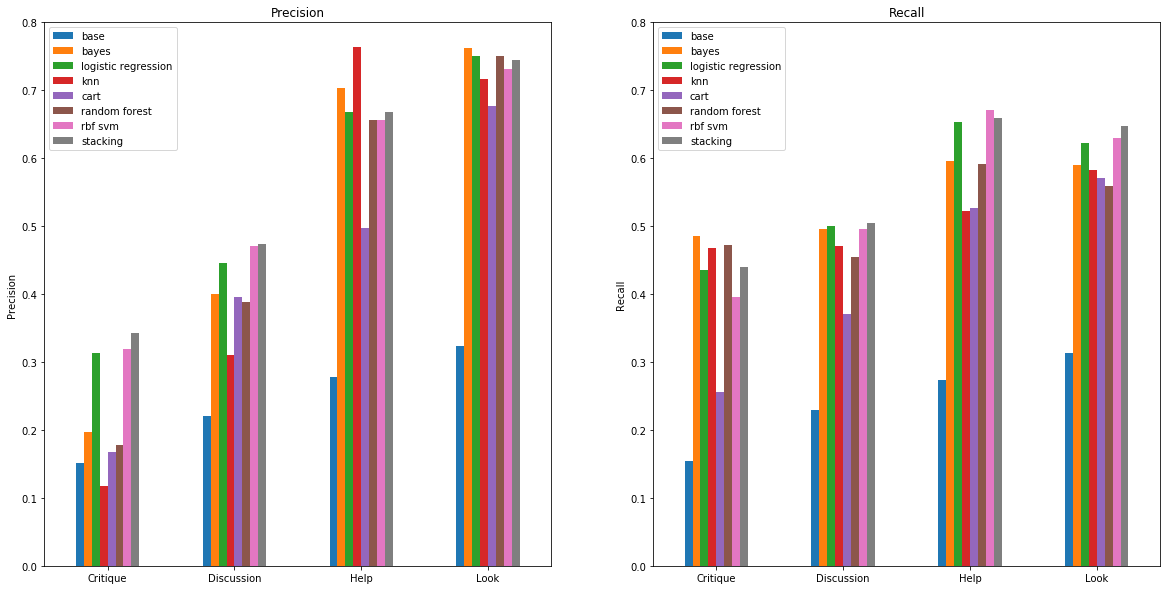

In [14]:
fig, (axs) = plt.subplots(nrows = 1, ncols=2, sharex = True, sharey = False,  figsize=(20,10))

prec_plot = all_prec.plot(kind = 'bar', ax = axs[1], rot = 0)
axs[0].set_title("Precision")
axs[0].set_ylabel("Precision")
axs[0].set_ylim([0,0.8])


rec_plot=all_recall.plot(kind = 'bar', ax = axs[0], rot = 0)
axs[1].set_title("Recall")
axs[1].set_ylabel("Recall")
axs[1].set_ylim([0,0.8])


plt.show()

* The precision is the ratio of correctly predicted positive observations to the total predicted positive observations. In other words, for a given Flair, how many of the observations predicted in this class actually belong to it. 
* The recall is the ratio of correctly predicted positive observations to the all observations in actual class. In other words, for a given Flair, how many of the observations belonging to it were correctly identified. 

### Precision and recall across all models
As we have observed previously with all the different models, we can see that the precision tends to be way better rof Help and Look (consistently above 50%) than for Critique and Discussion (consistently below 50%), whichever model (excecption for the dummy classifier). 
Help and Look are thus, the two classes for which, most of the posts predicted in each, actually belong to these classes. For Help and Look, most of the posts that are predicted in these classes, actually belong to other Categories. 
The bayes classifier is the one with the best precision for Critique, followed by the rbf svm, the logistic regression and the stacking classifier. The knn, decision tree and random forest classifiers demonstrate very low precision for Critique, actually performing worse than the dummy classifiers. This could be explained by the fact that for all of these methods, the criteria used is based on the homogeneity between the sample to predict and its neighbours. As observed during the exploratory data analysis, our data is very noisy, increasing the difficulty to obtain homogeneous groups of neighbors. 
An argument in favor of this interpretation, is the fact that the knn classifier outperforms all over classifiers on precision for the Help flair. Indeed, on the PCA performed in the Exploratory data analysis, we could observe that a subgroup of Help posts seemed to be in opposition with all categories on the second component. This homogenous group of Help posts, might be why a boost in precision was obtained for the knn classifier. For the Look category, all models (except for the dummy classifiers) have consistent precision, with stacking out performing all of them, showing that learning from the 0-level models allowed it to improve its predictions for this class in particular. 

The recall tended to be better than the precision for Critique and Discussion, and worse than the precision for Help and Look. In particular, we can see that the stacking classifier outperformed all over classifiers on recall for both Flairs, meaning that learning from the 0-level classifiers, allowed it to detect more of the posts actually belonging to these categories. 


## 4) Discussion

### Results summary

The goal of this project was to compare different models in order to build a classifier able to classify reddit posts according to flairs based on the content of the posts. The ultimate goal would be to retroactively categorize posts without flairs, to help users of the r/sourdough subreddit to include all posts when filtering the subreddit per flairs. 
After comparing 7 different models, we have reached the following results: 
* overall, classifying the posts, using the titles, other text content and comments, using a TF-IDF vectorizer to represent numerically the data is difficult to achieve. The best overall f1-score achieved was 58% with the stacking classifier
* There is no model completely above the others in terms of classification. The one we would choose would depend of what is more important for us: If we are more interested in being sure to detect the most Critique posts, as they are in lesser quantity, the Stacking classifier would be best as it is the one with the best recall for this category. If we want to make sure that we make the less errors for the Critique posts, the Naive Bayes classifier would be a better choice as it has the best precision for this category. 
* In all case, it is better to train any classifier than predicting at random, based on the Flair distribution in the dataset. 

### Limits and perspective
Working with real world data always have its challenges. There is no perfect setup, and numerous choices have been made. 

#### Flair reconciliation
Firstly, we should consider the target variable. There were about 40 Flairs in the original data set, all having vastly differing numbers of observations in the dataset. We chose to reconcile them, based on our knowledge of what the flairs represent, which means that this process was dependant on our own subjectivity. Another, more objective way of dealing with this, could have been to use some unsupervised classification method (such as k-clustering), to try and find clusters of flairs correlating together and use these to redefine new supergroups. However, this would have mean trying to fine tune the optimal numbers of clusters and would have not guaranteed homogene clusters of the original flairs. Another way could have been to only consider the Flairs active at the time of the project. While this would have significantly decrease the number of flairs, we would also have lost a lot of data. In addition, in a world where this classifier could be used as intended, this would raise the question on what to do each time the flairs would be changed.  

#### Data preprocessing
Secondly, we could look more closely at the preprocessing of the data. After lower casing, removing ursl and punctuation, stemming and tokenizing, we chose to perform some word corrections. In order to make this process cost efficient, we chose to apply the spell checker only of the words appearing only once in the whole corpus. While this allowed for the correction of some words, contributing to the reduction of the size of the vocabulary, some errors remained: words that the spellchecker wouldn't know, mising spaces betwee words, etc. In an ideal world, with more time and/or ressources, all words of the vocabulary would be checked, to correct them. We chose this solution, that allowed us the trade off of improving the quality of our dataset while being cost efficient, even if not perfect. 

Another way to go further in this project would be to try other ways of embedding the text data. For this project, we chose to use a bag of words approach, paired with different machine learning models. However, as mentionned during the EDA, other mthods exist. The bag of words approach as the inconvenient to lose any context on how words are used in a sentence. Other approaches, context sensitive can be used. In particular, during the early stages of the project, we were interested in using a BERT model without fine-tuning as a feature extractor to extract the most important high level features in the data. In the end, we chose to stick with the TF-IDF vectorizer, as it provided us with more opportunity to understand what were the more important features in the models we trained. In addition, using BERT without fine tuning as a feature extractor didn't seem to generally be good technique, compared to simply fine tuning a BERT model. Even if BERT models have been on the rise for Natural Language Processing tasks in the recent years, achieving state-of-the art results in many NLP tasks, there are no garantees that BERT can achieve better results if the text that is to be classified is specialized and different from the text used for the training. In addition, training a BERT model from scratch is extremely computationally expensive, and would not have been possble for this project. However, we would definitely want to explore this road in the future. 

#### TF-IDF Vectorizer tuning
Thirdly, we should consider the TF-IDF vectorizer: the choice was made to fine tune it with a single classifier, then use  the resulting dataset as input for all classifiers in the project. While fine tuning the TF-IDF at the same time as the classifier would have been an option, we chose our aproahc for two reason: Ensure the consistency of the input data between all models, and computational efficiency. Indeed, some of the models that were considered, wer already very computationally expensive to fine tune with only one training set: increasing the number of fits during the grid search, would have been too much for this machine. 

#### Class imbalance
Fourthly, we need to discuss the class imbalance and how it was deelt with. Even after reconciling the Flairs into super categories, there was still a class imbalance, with Look being twice as frequent as Critique. Three main ways can be considered to deal with imbalance: 
* First, downsampling, meaning we remove at random observations in the classes with the most observations, in order to match the class with the least observation. This has the disadvantage of removing information in the dataset, at the risk of all classes to be badly predicted as all classes have low numbers of observations. 
* Secondly, up sampling, meaning that we duplicate observations at random in the classes with the least observations until we match the number of observations in the majority class. This has the disadvantage of artificially reducing variance in the minority class. A way of mitigating it can be to use some data augmentation techniques, such as SMOTE (Synthetic Minority Over-sampling Technique), where random observations are duplicated and modified, based on its closest neighbors). However, there is no garantee that using these kind of techniques would effectively improve the classification performance of our models and indeed, in our case, SMOTE would probably be a poor choice as we have established that models relying on the proximity between an observation and its neighbors performed badly due to the noise in the data. 
* Finally, we can use cost-sensitive approaches, where imbalance is delt with at the model level, and not at the data level. With this method, the cost of prediction error is taken into account when training the model. A simple way to implement this is to simply adjust weights inversely proportional to class frequencies in the input data. 

The last approach is the one we chose as it was implemented in a multitude of the machine learning that we used, and didn't have the downfalls of the other two methods. However, this was not optimal as for two of the KNN classifier this option didn't exist (note, in the case of bayes, the option didn't exist per say, but it can be argued that fitting the prior with the class distribution in the dataset, might play a similar role). However, as we didn't want to lose information, nor artificially change the variance in our dataset, we chose to stick with the cost-sensitive approach. 
Using resampling techniques to deal with the class imbalance and study how they could affect the predictive performances of our models could be an additional route to pursue. 
